<h1 style="background-color:Green; color:white" >Importing Libraries</h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import cohen_kappa_score,accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.feature_selection import RFE
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# metrics 
from sklearn.metrics import cohen_kappa_score,accuracy_score,roc_auc_score,roc_curve
from sklearn.metrics import f1_score,confusion_matrix,classification_report
from sklearn.feature_selection import RFE
from sklearn.metrics import recall_score,precision_score,accuracy_score

#stats
from scipy import stats
import statsmodels.api as sma
import statsmodels.formula.api as sfa
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Evaluate the model
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder

<h1 style="background-color:DodgerBlue; color:white" >Importing the file</h1>

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
df = pd.read_csv('bank-full.csv',sep=';')
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no


In [5]:
df.shape

(45211, 17)

In [6]:
df1  = df.copy(deep = True)

* Treating the unknown in poutcome
* changing all the poutcome (unknown) to previous not contact 
* because all the unknown have not beem contacted we can see that from pdays and previous  

In [7]:
s = {'unknown':'prev_non_contact'}
df1['poutcome'] = df1['poutcome'].replace(s,regex=True)

<h2><span class="label label-primary">Statistical Analysis</span></h2>

**Performing Chi square test for categorical variables to find the significance**

* Ho: that the predictor is independent of target ( the predictor and target are not related)
* H1: that the predictor dependent of target

In [8]:
cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome']

In [9]:
for i in cat:
    tbl = pd.crosstab(df1[i],df1.y)
    teststats,pvalue,d,exp_freq = stats.chi2_contingency(tbl)
    print(f'Pvalue for {i} is {np.round(pvalue,5)}')

Pvalue for job is 0.0
Pvalue for marital is 0.0
Pvalue for education is 0.0
Pvalue for default is 0.0
Pvalue for housing is 0.0
Pvalue for loan is 0.0
Pvalue for contact is 0.0
Pvalue for month is 0.0
Pvalue for poutcome is 0.0


In [10]:
s = df1.copy(deep=True)

In [11]:
a = {'no':0,'yes':1}
s.y = s.y.replace(a)

**Performing Two_sample_ttest to find the significance between the independent numerical feature w.r.t to categorical target**

* Ho: that the predictor is independent of target ( the predictor and target are not related)
* H1: that the predictor dependent of target

In [12]:
# ttest ind for numerical values
cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
for i in cols:
    zero = s.loc[s.y==0,i]
    one = s.loc[s.y==1, i]
    teststats, pvalue = stats.ttest_ind(zero,one)
    print(f'Pvalue for {i} is {np.round(pvalue,5)}')

Pvalue for age is 0.0
Pvalue for balance is 0.0
Pvalue for day is 0.0
Pvalue for duration is 0.0
Pvalue for campaign is 0.0
Pvalue for pdays is 0.0
Pvalue for previous is 0.0


<h2><span class="label label-primary">Encoding</span></h2>

In [13]:
df2 = df1.copy(deep=True)

In [14]:
d={'no':0,'yes':1}
df2['y'] = df2['y'].replace(d)
df2.default = df2.default.map(d)
df2.housing = df2.housing.map(d)
df2.loan = df2.loan.map(d)

#### Frequency encoding

In [15]:
a=['education','poutcome']

In [16]:
for i in a:
    b =df2[i].value_counts(normalize=True)
    df2[i]=df2[i].map(b)

#### dummy encoding for marital,contact

In [17]:
df2 = pd.get_dummies(data=df2,columns=['marital'],drop_first=True)

In [18]:
df2 = pd.get_dummies(data=df2,columns=['contact'],drop_first=True)

In [19]:
c = ['job','month']

#### Label encoding for job and month

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
le = LabelEncoder()

In [22]:
df2['job']= le.fit_transform(df2['job'])

In [23]:
df2['month']= le.fit_transform(df2['month'])

In [24]:
df2.head(2)

,age,job,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y,marital_married,marital_single,contact_telephone,contact_unknown
0,58,4,0.294198,0,2143,1,0,5,8,261,1,-1,0,0.817478,0,1,0,0,1
1,44,9,0.513194,0,29,1,0,5,8,151,1,-1,0,0.817478,0,0,1,0,1


<h2><span class="label label-primary">Transformation </span></h2>

**Before transformation**

In [25]:
df1.skew() 

age          0.684818
balance      8.360308
day          0.093079
duration     3.144318
campaign     4.898650
pdays        2.615715
previous    41.846454
dtype: float64

In [26]:
df3 = df2.copy(deep=True)

In [27]:
a = ['balance', 'pdays','duration', 'campaign','previous']

In [28]:
from sklearn.preprocessing import PowerTransformer

In [29]:
b=PowerTransformer(method='yeo-johnson')

df3[a] = b.fit_transform(df3[a])

**After Transformation**

In [30]:
df3[['balance', 'pdays','duration', 'campaign','previous']].skew()

balance     1.098582
pdays       1.645213
duration    0.018045
campaign    0.230942
previous    1.646051
dtype: float64

<div class="alert alert-success" role="alert">
Skewness is reduced
</div>

<h2><span class="label label-primary">Scaling the data</span></h2>

In [31]:
df4 = df3.copy(deep=True)

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
ss = StandardScaler()

In [34]:
col = ['balance', 'duration','day', 'campaign', 'pdays', 'previous']

In [35]:
df4[col]= ss.fit_transform(df4[col])

In [36]:
df4.head(2)

,age,job,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y,marital_married,marital_single,contact_telephone,contact_unknown
0,58,4,0.294198,0,0.414773,1,0,-1.298476,8,0.386077,-1.108191,-0.472533,-0.4725,0.817478,0,1,0,0,1
1,44,9,0.513194,0,-0.410774,1,0,-1.298476,8,-0.223033,-1.108191,-0.472533,-0.4725,0.817478,0,0,1,0,1


<h2><span class="label label-primary">Building the models</span></h2>

**Writing functions**

In [141]:
lg   = LogisticRegression(random_state=10)
dt   = DecisionTreeClassifier(random_state=10)
rf   = RandomForestClassifier(random_state=10)
knn  = KNeighborsClassifier()
gb   = GaussianNB()
ada  = AdaBoostClassifier(random_state=10)
gbm  = GradientBoostingClassifier(random_state=10)
xgb  = XGBClassifier(random_state=10)
lgbm = LGBMClassifier(random_state=10)

In [38]:
l1 = [lg,dt,rf,knn,gb,ada,gbm,xgb,lgbm]

In [39]:
from sklearn.metrics import recall_score,precision_score,accuracy_score

In [40]:
def models(mod,xtrain,ytrain,xtest,ytest):
    l = [str(mod).split('(')[0]]
    model1 = mod.fit(xtrain,ytrain)
    ypred = model1.predict(xtest)  
    l.append(model1.score(xtrain,ytrain))   # Training accuracy
    l.append(model1.score(xtest,ytest))     # Testing accuracy
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(ytest,ypred).ravel()
    l.append(tn)   
    l.append(fp)
    l.append(fn)
    l.append(tp)
    
    l.append(round(recall_score(ytest,ypred),2))     # recall score
    l.append(round(precision_score(ytest,ypred),2))  # Presicion score
    l.append(round(f1_score(ytest,ypred),2))        # f1 score
    return l

In [41]:
best = pd.DataFrame(columns = ['Model','Train_ACC','Test_ACC','TN','FP','FN','TP','recall','Precision','F1 score'])

### Before SMOTE 

In [42]:
x = df4.drop(columns='y',axis=1)
y = df4['y']

In [43]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

**Stats Model**

In [44]:
temp_train =  sma.add_constant(xtrain)
temp_test = sma.add_constant(xtest)
model = sma.Logit(ytrain,temp_train).fit()
y_pred_prob = model.predict(temp_test)
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]
print(confusion_matrix(ytest,y_pred))
print(classification_report(ytest,y_pred))

Optimization terminated successfully.
         Current function value: 0.245978
         Iterations 8
[[7778  216]
 [ 760  289]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7994
           1       0.57      0.28      0.37      1049

    accuracy                           0.89      9043
   macro avg       0.74      0.62      0.66      9043
weighted avg       0.87      0.89      0.87      9043



In [45]:
perf1 = models(lg,xtrain,ytrain,xtest,ytest)
perf2 = models(dt,xtrain,ytrain,xtest,ytest)
perf3 = models(rf,xtrain,ytrain,xtest,ytest)
perf4 = models(knn,xtrain,ytrain,xtest,ytest)
perf5 = models(gb,xtrain,ytrain,xtest,ytest)
perf6 = models(ada,xtrain,ytrain,xtest,ytest)
perf7 = models(gbm,xtrain,ytrain,xtest,ytest)
perf8 = models(xgb,xtrain,ytrain,xtest,ytest)
perf9 = models(lgbm,xtrain,ytrain,xtest,ytest)

In [46]:
best.loc[len(best)] = perf1
best.loc[len(best)] = perf2
best.loc[len(best)] = perf3
best.loc[len(best)] = perf4
best.loc[len(best)] = perf5
best.loc[len(best)] = perf6
best.loc[len(best)] = perf7
best.loc[len(best)] = perf8
best.loc[len(best)] = perf9

In [47]:
best.sort_values(by='F1 score',ascending=False)

,Model,Train_ACC,Test_ACC,TN,FP,FN,TP,recall,Precision,F1 score
7,XGBClassifier,0.953661,0.910096,7705,289,524,525,0.50,0.64,0.56
8,LGBMClassifier,0.929579,0.910870,7720,274,532,517,0.49,0.65,0.56
2,RandomForestClassifier,0.999972,0.905120,7751,243,615,434,0.41,0.64,0.50
6,GradientBoostingClassifier,0.908980,0.905894,7764,230,621,428,0.41,0.65,0.50
1,DecisionTreeClassifier,1.000000,0.875373,7436,558,569,480,0.46,0.46,0.46
5,AdaBoostClassifier,0.900852,0.898043,7745,249,673,376,0.36,0.60,0.45
4,GaussianNB,0.804274,0.806701,6802,1192,556,493,0.47,0.29,0.36
0,LogisticRegression,0.892363,0.889749,7787,207,790,259,0.25,0.56,0.34
3,KNeighborsClassifier,0.913045,0.885768,7776,218,815,234,0.22,0.52,0.31


* In Base model without smote the maximum f1 score achived is 0.56 in XGB,LGBM

### After SMOTE

In [48]:
x = df4.drop(columns='y',axis=1)
y = df4['y']

In [49]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

In [50]:
smote = SMOTE(sampling_strategy='minority')
xtrain,ytrain = smote.fit_resample(xtrain,ytrain)

**Stats Model**

In [51]:
temp_train =  sma.add_constant(xtrain)
temp_test = sma.add_constant(xtest)
model = sma.Logit(ytrain,temp_train).fit()
y_pred_prob = model.predict(temp_test)
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]
print(confusion_matrix(ytest,y_pred))
print(classification_report(ytest,y_pred))

Optimization terminated successfully.
         Current function value: 0.340659
         Iterations 7
[[6679 1315]
 [ 301  748]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.89      7994
           1       0.36      0.71      0.48      1049

    accuracy                           0.82      9043
   macro avg       0.66      0.77      0.69      9043
weighted avg       0.89      0.82      0.84      9043



In [52]:
best1 = pd.DataFrame(columns = ['Model','Train_ACC','Test_ACC','TN','FP','FN','TP','recall','Precision','F1 score'])

In [53]:
perf1 = models(lg,xtrain,ytrain,xtest,ytest)
perf2 = models(dt,xtrain,ytrain,xtest,ytest)
perf3 = models(rf,xtrain,ytrain,xtest,ytest)
perf4 = models(knn,xtrain,ytrain,xtest,ytest)
perf5 = models(gb,xtrain,ytrain,xtest,ytest)
perf6 = models(ada,xtrain,ytrain,xtest,ytest)
perf7 = models(gbm,xtrain,ytrain,xtest,ytest)
perf8 = models(xgb,xtrain,ytrain,xtest,ytest)
perf9 = models(lgbm,xtrain,ytrain,xtest,ytest)

In [54]:
best1.loc[len(best1)] = perf1
best1.loc[len(best1)] = perf2
best1.loc[len(best1)] = perf3
best1.loc[len(best1)] = perf4
best1.loc[len(best1)] = perf5
best1.loc[len(best1)] = perf6
best1.loc[len(best1)] = perf7
best1.loc[len(best1)] = perf8
best1.loc[len(best1)] = perf9

In [55]:
best1.sort_values(by='F1 score',ascending=False)

,Model,Train_ACC,Test_ACC,TN,FP,FN,TP,recall,Precision,F1 score
8,LGBMClassifier,0.947710,0.903572,7529,465,407,642,0.61,0.58,0.60
7,XGBClassifier,0.969979,0.903904,7603,391,478,571,0.54,0.59,0.57
6,GradientBoostingClassifier,0.915811,0.875705,7196,798,326,723,0.69,0.48,0.56
2,RandomForestClassifier,1.000000,0.888533,7437,557,451,598,0.57,0.52,0.54
5,AdaBoostClassifier,0.896752,0.860997,7118,876,381,668,0.64,0.43,0.52
0,LogisticRegression,0.851228,0.814110,6614,1380,301,748,0.71,0.35,0.47
3,KNeighborsClassifier,0.936999,0.816654,6668,1326,332,717,0.68,0.35,0.46
1,DecisionTreeClassifier,1.000000,0.852483,7170,824,510,539,0.51,0.40,0.45
4,GaussianNB,0.751926,0.627778,4916,3078,288,761,0.73,0.20,0.31


* In Base model after smote the maximum f1 score achieved is 0.60,0.57,0.56 by  LGBM, XGB,Gradient Boosting
* The highest TP is achieved by Logistic Regression,Gaussian NB Model at a f1 score of 0.47,0.31

In [56]:
feature_imp = pd.DataFrame()
feature_imp['Features'] = xtrain.columns
feature_imp['Importance'] = lgbm.feature_importances_

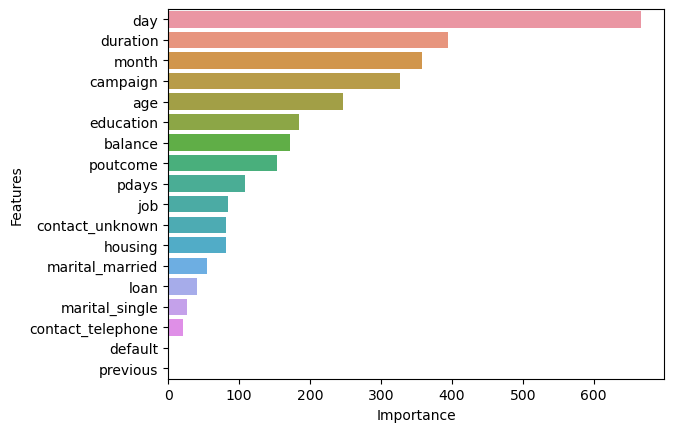

In [57]:
feature_imp1=feature_imp.sort_values(by='Importance',ascending=False)
sns.barplot(x='Importance',y='Features',data=feature_imp1)
plt.show()

<h2><span class="label label-primary">Adding Features</span></h2>

**1.Per call time**

* Per call time feature is the duration divided by number of calls

In [58]:
df5 = df4.copy(deep=True)

In [59]:
df5['per_call_time'] = round((df1.duration/(df1.campaign*60)),2)

In [60]:
df5[['per_call_time']]= ss.fit_transform(df5[['per_call_time']])

In [61]:
best2 = pd.DataFrame(columns = ['Model','Train_ACC','Test_ACC','TN','FP','FN','TP','recall','Precision','F1 score'])

In [62]:
x = df5.drop(columns='y',axis=1)
y = df5['y']

In [63]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

In [64]:
smote = SMOTE(sampling_strategy='minority')
xtrain,ytrain = smote.fit_resample(xtrain,ytrain)

In [65]:
perf1 = models(lg,xtrain,ytrain,xtest,ytest)
perf2 = models(dt,xtrain,ytrain,xtest,ytest)
perf3 = models(rf,xtrain,ytrain,xtest,ytest)
perf4 = models(knn,xtrain,ytrain,xtest,ytest)
perf5 = models(gb,xtrain,ytrain,xtest,ytest)
perf6 = models(ada,xtrain,ytrain,xtest,ytest)
perf7 = models(gbm,xtrain,ytrain,xtest,ytest)
perf8 = models(xgb,xtrain,ytrain,xtest,ytest)
perf9 = models(lgbm,xtrain,ytrain,xtest,ytest)

In [66]:
best2.loc[len(best2)] = perf1
best2.loc[len(best2)] = perf2
best2.loc[len(best2)] = perf3
best2.loc[len(best2)] = perf4
best2.loc[len(best2)] = perf5
best2.loc[len(best2)] = perf6
best2.loc[len(best2)] = perf7
best2.loc[len(best2)] = perf8
best2.loc[len(best2)] = perf9

In [67]:
best2.sort_values(by='F1 score',ascending=False)

,Model,Train_ACC,Test_ACC,TN,FP,FN,TP,recall,Precision,F1 score
8,LGBMClassifier,0.947429,0.903461,7528,466,407,642,0.61,0.58,0.60
2,RandomForestClassifier,1.000000,0.890302,7426,568,424,625,0.60,0.52,0.56
6,GradientBoostingClassifier,0.916186,0.873383,7179,815,330,719,0.69,0.47,0.56
7,XGBClassifier,0.969823,0.904235,7618,376,490,559,0.53,0.60,0.56
5,AdaBoostClassifier,0.895578,0.860334,7102,892,371,678,0.65,0.43,0.52
0,LogisticRegression,0.848566,0.814221,6612,1382,298,751,0.72,0.35,0.47
3,KNeighborsClassifier,0.938142,0.816654,6662,1332,326,723,0.69,0.35,0.47
1,DecisionTreeClassifier,1.000000,0.850824,7151,843,506,543,0.52,0.39,0.45
4,GaussianNB,0.784860,0.678425,5357,2637,271,778,0.74,0.23,0.35


* In Base model after smote the maximum f1 score achieved is LGBM(0.60),XGB(0.57),Gradient Boosting(0.56)
* Adding per_call_time feature, the f1_score of LGBM(0.60),GBM(0.56),XGB(0.56) 

**2.Binning of job**

In [68]:
df6 = df4.copy(deep=True)

In [69]:
unemp = ['student','unemployed','retired','unknown']
blue  = ['blue-collar','technician','services','housemaid','self-employed']
white = ['management','admin.','entrepreneur']

In [70]:
l = []
for i in df1.job:
    if i in unemp:
        l.append('unemployed')
    elif i in blue:
        l.append('blue-collar')
    elif i in white:
        l.append('white-collar')

In [71]:
df6['job_binned']=l 

In [72]:
b =df6['job_binned'].value_counts(normalize=True)
df6['job_binned']=df6['job_binned'].map(b)

In [73]:
x = df6.drop(columns='y',axis=1)
y = df6['y']

In [74]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

In [75]:
smote = SMOTE(sampling_strategy='minority')
xtrain,ytrain = smote.fit_resample(xtrain,ytrain)

In [76]:
best3 = pd.DataFrame(columns = ['Model','Train_ACC','Test_ACC','TN','FP','FN','TP','recall','Precision','F1 score'])

In [77]:
perf1 = models(lg,xtrain,ytrain,xtest,ytest)
perf2 = models(dt,xtrain,ytrain,xtest,ytest)
perf3 = models(rf,xtrain,ytrain,xtest,ytest)
perf4 = models(knn,xtrain,ytrain,xtest,ytest)
perf5 = models(gb,xtrain,ytrain,xtest,ytest)
perf6 = models(ada,xtrain,ytrain,xtest,ytest)
perf7 = models(gbm,xtrain,ytrain,xtest,ytest)
perf8 = models(xgb,xtrain,ytrain,xtest,ytest)
perf9 = models(lgbm,xtrain,ytrain,xtest,ytest)

In [78]:
best3.loc[len(best3)] = perf1
best3.loc[len(best3)] = perf2
best3.loc[len(best3)] = perf3
best3.loc[len(best3)] = perf4
best3.loc[len(best3)] = perf5
best3.loc[len(best3)] = perf6
best3.loc[len(best3)] = perf7
best3.loc[len(best3)] = perf8
best3.loc[len(best3)] = perf9

In [79]:
best3.sort_values(by='F1 score',ascending=False)

,Model,Train_ACC,Test_ACC,TN,FP,FN,TP,recall,Precision,F1 score
8,LGBMClassifier,0.948337,0.904567,7551,443,420,629,0.60,0.59,0.59
6,GradientBoostingClassifier,0.919193,0.878359,7224,770,330,719,0.69,0.48,0.57
7,XGBClassifier,0.968210,0.905562,7632,362,492,557,0.53,0.61,0.57
2,RandomForestClassifier,1.000000,0.890634,7470,524,465,584,0.56,0.53,0.54
5,AdaBoostClassifier,0.899524,0.867411,7171,823,376,673,0.64,0.45,0.53
0,LogisticRegression,0.854438,0.817317,6648,1346,306,743,0.71,0.36,0.47
1,DecisionTreeClassifier,1.000000,0.856685,7202,792,504,545,0.52,0.41,0.46
3,KNeighborsClassifier,0.936513,0.813557,6665,1329,357,692,0.66,0.34,0.45
4,GaussianNB,0.756562,0.634082,4972,3022,287,762,0.73,0.20,0.32


* In Base model after smote the maximum f1 score achieved is LGBM(0.60), XGB(0.57), Gradient Boosting(0.56)
* Adding per_call_time feature, the f1_score of LGBM(0.59), GBM(0.56), and Guassian NB has low f1_score
* Adding the job category maximum f1 score achieved is LGBM(0.59), XGB(0.57), Gradient Boosting(0.57)

**3.Binning of Age**

In [80]:
df7 = df4.copy(deep=True)

In [81]:
l=[]
for i in df1['age']:
    if (i>=18) & (i<=39):
        a='young'
        l.append(a)
    elif (i>=40) & (i<=60):
        a='adult'
        l.append(a)
    elif (i>=61) :
        a='old'
        l.append(a)

In [82]:
df7['age_binned'] = l 

In [83]:
b =df7['age_binned'].value_counts(normalize=True)
df7['age_binned']=df7['age_binned'].map(b)

In [84]:
x = df7.drop(columns='y',axis=1)
y = df7['y']

In [91]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

In [92]:
smote = SMOTE(sampling_strategy='minority')
xtrain,ytrain = smote.fit_resample(xtrain,ytrain)

In [93]:
best4 = pd.DataFrame(columns = ['Model','Train_ACC','Test_ACC','TN','FP','FN','TP','recall','Precision','F1 score'])

In [94]:
perf1 = models(lg,xtrain,ytrain,xtest,ytest)
perf2 = models(dt,xtrain,ytrain,xtest,ytest)
perf3 = models(rf,xtrain,ytrain,xtest,ytest)
perf4 = models(knn,xtrain,ytrain,xtest,ytest)
perf5 = models(gb,xtrain,ytrain,xtest,ytest)
perf6 = models(ada,xtrain,ytrain,xtest,ytest)
perf7 = models(gbm,xtrain,ytrain,xtest,ytest)
perf8 = models(xgb,xtrain,ytrain,xtest,ytest)
perf9 = models(lgbm,xtrain,ytrain,xtest,ytest)

In [95]:
best4.loc[len(best4)] = perf1
best4.loc[len(best4)] = perf2
best4.loc[len(best4)] = perf3
best4.loc[len(best4)] = perf4
best4.loc[len(best4)] = perf5
best4.loc[len(best4)] = perf6
best4.loc[len(best4)] = perf7
best4.loc[len(best4)] = perf8
best4.loc[len(best4)] = perf9

In [96]:
best4.sort_values(by='F1 score',ascending=False)

,Model,Train_ACC,Test_ACC,TN,FP,FN,TP,recall,Precision,F1 score
8,LGBMClassifier,0.948713,0.904678,7554,440,422,627,0.60,0.59,0.59
6,GradientBoostingClassifier,0.917001,0.876921,7197,797,316,733,0.70,0.48,0.57
7,XGBClassifier,0.967646,0.903572,7602,392,480,569,0.54,0.59,0.57
2,RandomForestClassifier,1.000000,0.891297,7448,546,437,612,0.58,0.53,0.55
5,AdaBoostClassifier,0.897833,0.861772,7129,865,385,664,0.63,0.43,0.52
0,LogisticRegression,0.854062,0.815659,6630,1364,303,746,0.71,0.35,0.47
1,DecisionTreeClassifier,1.000000,0.858012,7217,777,507,542,0.52,0.41,0.46
3,KNeighborsClassifier,0.936451,0.813889,6667,1327,356,693,0.66,0.34,0.45
4,GaussianNB,0.778752,0.673781,5313,2681,269,780,0.74,0.23,0.35


* In Base model after smote the maximum f1 score achieved is LGBM(0.60), XGB(0.57), Gradient Boosting(0.56)
* Adding per_call_time feature, the f1_score of LGBM(0.59), GBM(0.56), and Guassian NB has low f1_score
* Adding the job category maximum f1 score achieved is LGBM(0.59), XGB(0.57), Gradient Boosting(0.57)
* Adding the age category maximum f1 score achieved is LGBM(0.59), XGB(0.57), Gradient Boosting(0.57)

**4.Binning of month**

In [97]:
df8 = df4.copy(deep=True)

In [98]:
f1 = ['jan','feb','mar']
f2 = ['apr','may','jun']
f3 = ['jul','aug','sep']
f4 = ['oct','nov','dec']

In [99]:
l1 = []
for i in df1.month:
    if i in f1:
        l1.append('first_quarter')
    elif i in f2:
        l1.append('second_quarter')
    elif i in f3:
        l1.append('third_quarter')
    elif i in f4:
        l1.append('fourth_quarter')

In [100]:
df8['month_binned'] = l1

In [101]:
b =df8['month_binned'].value_counts(normalize=True)
df8['month_binned']=df8['month_binned'].map(b)

In [102]:
x = df8.drop(columns='y',axis=1)
y = df8['y']

In [103]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

In [104]:
smote = SMOTE(sampling_strategy='minority')
xtrain,ytrain = smote.fit_resample(xtrain,ytrain)

In [105]:
best5 = pd.DataFrame(columns = ['Model','Train_ACC','Test_ACC','TN','FP','FN','TP','recall','Precision','F1 score'])

In [106]:
perf1 = models(lg,xtrain,ytrain,xtest,ytest)
perf2 = models(dt,xtrain,ytrain,xtest,ytest)
perf3 = models(rf,xtrain,ytrain,xtest,ytest)
perf4 = models(knn,xtrain,ytrain,xtest,ytest)
perf5 = models(gb,xtrain,ytrain,xtest,ytest)
perf6 = models(ada,xtrain,ytrain,xtest,ytest)
perf7 = models(gbm,xtrain,ytrain,xtest,ytest)
perf8 = models(xgb,xtrain,ytrain,xtest,ytest)
perf9 = models(lgbm,xtrain,ytrain,xtest,ytest)

In [107]:
best5.loc[len(best5)] = perf1
best5.loc[len(best5)] = perf2
best5.loc[len(best5)] = perf3
best5.loc[len(best5)] = perf4
best5.loc[len(best5)] = perf5
best5.loc[len(best5)] = perf6
best5.loc[len(best5)] = perf7
best5.loc[len(best5)] = perf8
best5.loc[len(best5)] = perf9

In [108]:
best5.sort_values(by='F1 score',ascending=False)

,Model,Train_ACC,Test_ACC,TN,FP,FN,TP,recall,Precision,F1 score
8,LGBMClassifier,0.948619,0.905120,7536,458,400,649,0.62,0.59,0.60
2,RandomForestClassifier,1.000000,0.898706,7512,482,434,615,0.59,0.56,0.57
6,GradientBoostingClassifier,0.921433,0.883003,7288,706,352,697,0.66,0.50,0.57
7,XGBClassifier,0.969337,0.904899,7620,374,486,563,0.54,0.60,0.57
5,AdaBoostClassifier,0.900761,0.863651,7157,837,396,653,0.62,0.44,0.51
0,LogisticRegression,0.852669,0.813447,6608,1386,301,748,0.71,0.35,0.47
1,DecisionTreeClassifier,1.000000,0.860113,7211,783,482,567,0.54,0.42,0.47
3,KNeighborsClassifier,0.937469,0.813779,6651,1343,341,708,0.67,0.35,0.46
4,GaussianNB,0.752083,0.627447,4912,3082,287,762,0.73,0.20,0.31


* In Base model after smote the maximum f1 score achieved is LGBM(0.60), XGB(0.57), Gradient Boosting(0.56)
* Adding per_call_time feature, the f1_score of LGBM(0.59), GBM(0.56), and Guassian NB has low f1_score
* Adding the job category maximum f1 score achieved is LGBM(0.59), XGB(0.57), Gradient Boosting(0.57)
* Adding the age category maximum f1 score achieved is LGBM(0.59), XGB(0.57), Gradient Boosting(0.57)
* Adding the month categoty maximum f1 score achieved is LGBM(0.60), XGB(0.57), Gradient Boosting(0.57)

#### 5. Adding all the features

In [109]:
df9 = df4.copy(deep=True)

In [110]:
df9.head()

,age,job,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y,marital_married,marital_single,contact_telephone,contact_unknown
0,58,4,0.294198,0,0.414773,1,0,-1.298476,8,0.386077,-1.108191,-0.472533,-0.4725,0.817478,0,1,0,0,1
1,44,9,0.513194,0,-0.410774,1,0,-1.298476,8,-0.223033,-1.108191,-0.472533,-0.4725,0.817478,0,0,1,0,1
2,33,2,0.513194,0,-0.431122,1,1,-1.298476,8,-0.923854,-1.108191,-0.472533,-0.4725,0.817478,0,1,0,0,1
3,47,1,0.041074,0,0.197685,1,0,-1.298476,8,-0.735678,-1.108191,-0.472533,-0.4725,0.817478,0,1,0,0,1
4,33,11,0.041074,0,-0.432119,0,0,-1.298476,8,0.072812,-1.108191,-0.472533,-0.4725,0.817478,0,0,1,0,1


In [111]:
df9.shape

(45211, 19)

In [112]:
df9['per_call_time'] = round((df1.duration/(df1.campaign*60)),2)

In [113]:
unemp = ['student','unemployed','retired','unknown']
blue  = ['blue-collar','technician','services','housemaid','self-employed']
white = ['management','admin.','entrepreneur']

In [114]:
l = []
for i in df1.job:
    if i in unemp:
        l.append('unemployed')
    elif i in blue:
        l.append('blue-collar')
    elif i in white:
        l.append('white-collar')

In [115]:
df9['job_binned']=l 

In [116]:
l=[]
for i in df1['age']:
    if (i>=18) & (i<=39):
        a='young'
        l.append(a)
    elif (i>=40) & (i<=60):
        a='adult'
        l.append(a)
    elif (i>=61) :
        a='old'
        l.append(a)

In [117]:
df9['age_binned'] = l

In [118]:
f1 = ['jan','feb','mar',]
f2 = ['apr','may','jun']
f3 = ['jul','aug','sep']
f4 = ['oct','nov','dec']

In [119]:
l1 = []
for i in df1.month:
    if i in f1:
        l1.append('first_quarter')
    elif i in f2:
        l1.append('second_quarter')
    elif i in f3:
        l1.append('third_quarter')
    elif i in f4:
        l1.append('fourth_quarter')

In [120]:
df9['month_binned'] = l1

In [121]:
f = ['job_binned','age_binned','month_binned']
for i in f:
    b =df9[i].value_counts(normalize=True)
    df9[i]=df9[i].map(b)

In [122]:
df9[['per_call_time']]= ss.fit_transform(df9[['per_call_time']])

In [123]:
x = df9.drop(columns='y',axis=1)
y = df9['y']

In [124]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

In [125]:
smote = SMOTE(sampling_strategy='minority')
xtrain,ytrain = smote.fit_resample(xtrain,ytrain)

In [126]:
best6 = pd.DataFrame(columns = ['Model','Train_ACC','Test_ACC','TN','FP','FN','TP','recall','Precision','F1 score'])

In [127]:
perf1 = models(lg,xtrain,ytrain,xtest,ytest)
perf2 = models(dt,xtrain,ytrain,xtest,ytest)
perf3 = models(rf,xtrain,ytrain,xtest,ytest)
perf4 = models(knn,xtrain,ytrain,xtest,ytest)
perf5 = models(gb,xtrain,ytrain,xtest,ytest)
perf6 = models(ada,xtrain,ytrain,xtest,ytest)
perf7 = models(gbm,xtrain,ytrain,xtest,ytest)
perf8 = models(xgb,xtrain,ytrain,xtest,ytest)
perf9 = models(lgbm,xtrain,ytrain,xtest,ytest)

In [128]:
best6.loc[len(best6)] = perf1
best6.loc[len(best6)] = perf2
best6.loc[len(best6)] = perf3
best6.loc[len(best6)] = perf4
best6.loc[len(best6)] = perf5
best6.loc[len(best6)] = perf6
best6.loc[len(best6)] = perf7
best6.loc[len(best6)] = perf8
best6.loc[len(best6)] = perf9

In [129]:
best6.sort_values(by='F1 score',ascending=False)

,Model,Train_ACC,Test_ACC,TN,FP,FN,TP,recall,Precision,F1 score
8,LGBMClassifier,0.948932,0.906005,7549,445,405,644,0.61,0.59,0.60
7,XGBClassifier,0.970903,0.908548,7640,354,473,576,0.55,0.62,0.58
2,RandomForestClassifier,1.000000,0.893951,7468,526,433,616,0.59,0.54,0.56
6,GradientBoostingClassifier,0.923985,0.880018,7258,736,349,700,0.67,0.49,0.56
5,AdaBoostClassifier,0.904285,0.867080,7168,826,376,673,0.64,0.45,0.53
0,LogisticRegression,0.853765,0.816101,6635,1359,304,745,0.71,0.35,0.47
1,DecisionTreeClassifier,1.000000,0.861661,7240,754,497,552,0.53,0.42,0.47
3,KNeighborsClassifier,0.938158,0.816764,6665,1329,328,721,0.69,0.35,0.47
4,GaussianNB,0.802196,0.715913,5699,2295,274,775,0.74,0.25,0.38


* In Base model after smote the maximum f1 score achieved is LGBM(0.60), XGB(0.57), Gradient Boosting(0.56)
* Adding per_call_time feature, the f1_score of LGBM(0.59), GBM(0.56), and Guassian NB has low f1_score
* Adding the job category maximum f1 score achieved is LGBM(0.59), XGB(0.57), Gradient Boosting(0.57)
* Adding the age category maximum f1 score achieved is LGBM(0.59), XGB(0.57), Gradient Boosting(0.57)
* Adding the month categoty maximum f1 score achieved is LGBM(0.60), XGB(0.57), Gradient Boosting(0.57)
* After adding all the category  maximum f1 score achieved is LGBM(0.60), XGB(0.58), Gradient Boosting(0.56)

<h2><span class="label label-primary">Hyper parameter tunning</span></h2>

* Based on feature engineering we created multiple models, In that feature engineering with month binned has good scores
* From that LGBM,XGB,GB performed good, So were tunning the models to get better scores

In [158]:
x = df8.drop(columns='y',axis=1)
y = df8['y']

In [159]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

In [160]:
smote = SMOTE(sampling_strategy='minority')
xtrain,ytrain = smote.fit_resample(xtrain,ytrain)

<h3><span class="label label-info">LGBM</span></h3>

In [162]:
params = {'n_estimators':[100,150,200],
         'max_depth':range(2,10),
         'reg_lambda':[0.02,0.01,0.1,0.2,0.3]}
Grid  = GridSearchCV(estimator=lgbm,cv=5,param_grid=params,n_jobs=-1)
Grid.fit(xtrain,ytrain)
Grid.best_params_

{'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 0.02}

In [163]:
lgbm =  LGBMClassifier(random_state=10,max_depth=7,n_estimators=100,reg_lambda=0.02)
model2 = lgbm.fit(xtrain,ytrain)
ypred2 = model2.predict(xtest)  
print(model2.score(xtrain,ytrain))
print(model2.score(xtest,ytest))
print(confusion_matrix(ytest,ypred2))
print(classification_report(ytest,ypred2))

0.9477417940365823
0.9046776512219397
[[7514  480]
 [ 382  667]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7994
           1       0.58      0.64      0.61      1049

    accuracy                           0.90      9043
   macro avg       0.77      0.79      0.78      9043
weighted avg       0.91      0.90      0.91      9043



In [164]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

In [165]:
smote = SMOTE(sampling_strategy='minority')
smotex,smotey = smote.fit_resample(xtrain,ytrain)

In [166]:
pred = []

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

for train_index,test_index in kfold.split(smotex,smotey):
    xtrain = smotex.iloc[train_index]
    ytrain = smotey.iloc[train_index]
    pred.append(lgbm.fit(xtrain,ytrain).predict(xtest)) 

In [167]:
finalpred = pd.DataFrame(pred).T.mode(axis=1)[0]

In [168]:
print(confusion_matrix(ytest,finalpred))
print(classification_report(ytest,finalpred)) 

[[7507  487]
 [ 386  663]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7994
           1       0.58      0.63      0.60      1049

    accuracy                           0.90      9043
   macro avg       0.76      0.79      0.77      9043
weighted avg       0.91      0.90      0.91      9043



* after doing the hyper parameter tuning the FN is decreased and the TP is increased the f1 score also increased
* But the model predictions have been improved

<h3><span class="label label-info">XGB</span></h3>

In [ ]:
# params = {'max_depth':range(6,15),
#          'gamma':[0,1,2,3,4],
#          'subsample':[0.5,0.6,0.7,0.8,1]}

# Grid  = GridSearchCV(estimator=xgb,cv=5,param_grid=params,n_jobs=-1)

# Grid.fit(xtrain,ytrain)

# Grid.best_params_

In [169]:
xgb =  XGBClassifier(random_state=10,max_depth=6,gamma=0,subsample=0.8)
model2 = xgb.fit(xtrain,ytrain)
ypred2 = model2.predict(xtest)  
print(model2.score(xtrain,ytrain))
print(model2.score(xtest,ytest))
print(confusion_matrix(ytest,ypred2))
print(classification_report(ytest,ypred2))

0.9727904472937261
0.906668141103616
[[7613  381]
 [ 463  586]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7994
           1       0.61      0.56      0.58      1049

    accuracy                           0.91      9043
   macro avg       0.77      0.76      0.76      9043
weighted avg       0.90      0.91      0.91      9043



In [170]:
pred = []

kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

for train_index,test_index in kfold.split(smotex,smotey):
    xtrain = smotex.iloc[train_index]
    ytrain = smotey.iloc[train_index]
    pred.append(xgb.fit(xtrain,ytrain).predict(xtest)) 

In [171]:
finalpred = pd.DataFrame(pred).T.mode(axis=1)[0]

In [172]:
print(confusion_matrix(ytest,finalpred))
print(classification_report(ytest,finalpred)) 

[[7632  362]
 [ 464  585]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7994
           1       0.62      0.56      0.59      1049

    accuracy                           0.91      9043
   macro avg       0.78      0.76      0.77      9043
weighted avg       0.90      0.91      0.91      9043



<h3><span class="label label-info">Gradient Boosting</span></h3>

In [173]:
# params = {'n_estimators':[100,200,300],
#          'min_samples_split':range(2,5),
#          'min_samples_leaf':range(1,5),
#           'max_depth':[3,4,5,6,7]}

# grid = GridSearchCV(estimator=gb1,cv=5,n_jobs=-1,param_grid=params,scoring='f1')

# grid.fit(smotex,smotey)

# grid.best_params_

In [174]:
gbc =  GradientBoostingClassifier(max_depth=5,min_samples_leaf=4,min_samples_split=2,n_estimators=100)

model2 = gbc.fit(xtrain,ytrain)
ypred2 = model2.predict(xtest)  
print(model2.score(xtrain,ytrain))
print(model2.score(xtest,ytest))
print(confusion_matrix(ytest,ypred2))
print(classification_report(ytest,ypred2))

0.9433688949789566
0.8958310295255999
[[7424  570]
 [ 372  677]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7994
           1       0.54      0.65      0.59      1049

    accuracy                           0.90      9043
   macro avg       0.75      0.79      0.77      9043
weighted avg       0.90      0.90      0.90      9043



In [175]:
pred = []

kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

for train_index,test_index in kfold.split(smotex,smotey):
    xtrain = smotex.iloc[train_index]
    ytrain = smotey.iloc[train_index]
    pred.append(gbm.fit(xtrain,ytrain).predict(xtest))

In [176]:
finalpred = pd.DataFrame(pred).T.mode(axis=1)[0]

In [177]:
print(gbm.score(xtrain,ytrain))
print(gbm.score(xtest,ytest))
print(confusion_matrix(ytest,finalpred))
print(classification_report(ytest,finalpred)) 

0.9210384367768092
0.8793541966161672
[[7270  724]
 [ 343  706]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7994
           1       0.49      0.67      0.57      1049

    accuracy                           0.88      9043
   macro avg       0.72      0.79      0.75      9043
weighted avg       0.90      0.88      0.89      9043



<h3><span class="label label-info">Logistic Regression</span></h3>

In [178]:
lg = LogisticRegression(random_state=10)

In [179]:
params = {'penalty' :['l1', 'l2', 'elasticnet'],
         'C':[0.1, 0.5, 1, 5, 10, 50]}

Grid  = GridSearchCV(estimator=lg,cv=5,param_grid=params,n_jobs=-1)

Grid.fit(xtrain,ytrain)

Grid.best_params_

{'C': 5, 'penalty': 'l2'}

In [180]:
lg = LogisticRegression(random_state=10,C=5,penalty='l2')
model2 = lg.fit(xtrain,ytrain)
ypred2 = model2.predict(xtest)  
print(model2.score(xtrain,ytrain))
print(model2.score(xtest,ytest))
print(confusion_matrix(ytest,ypred2))
print(classification_report(ytest,ypred2))


0.8523255206973952
0.8154373548601128
[[6629 1365]
 [ 304  745]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      7994
           1       0.35      0.71      0.47      1049

    accuracy                           0.82      9043
   macro avg       0.65      0.77      0.68      9043
weighted avg       0.89      0.82      0.84      9043



In [193]:
feature_imp = pd.DataFrame()
feature_imp['Features'] = xtrain.columns
feature_imp['Importance'] = lgbm.feature_importances_

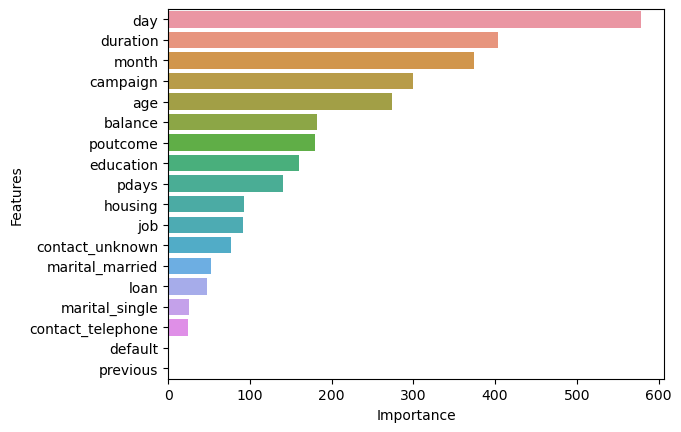

In [194]:
feature_imp1=feature_imp.sort_values(by='Importance',ascending=False)
sns.barplot(x='Importance',y='Features',data=feature_imp1)
plt.show()

#### Removing the defualt and previous from data and checking for improvement

In [181]:
df10 = df8.copy(deep=True)

In [182]:
df10.head(2)

,age,job,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y,marital_married,marital_single,contact_telephone,contact_unknown,month_binned
0,58,4,0.294198,0,0.414773,1,0,-1.298476,8,0.386077,-1.108191,-0.472533,-0.4725,0.817478,0,1,0,0,1,0.48747
1,44,9,0.513194,0,-0.410774,1,0,-1.298476,8,-0.223033,-1.108191,-0.472533,-0.4725,0.817478,0,0,1,0,1,0.48747


In [183]:
x = df10.drop(columns=['y','default','previous'],axis=1)
y = df10['y']

In [184]:
xtrain,xtest,ytrain,ytest =  train_test_split(x,y,test_size=0.20,random_state=10)

In [185]:
smote = SMOTE(sampling_strategy='minority')
xtrain,ytrain = smote.fit_resample(xtrain,ytrain)

In [187]:
lgb =  LGBMClassifier(random_state=10,max_depth=7,n_estimators=100,reg_lambda=0.02)
model2 = lgb.fit(xtrain,ytrain)
ypred2 = model2.predict(xtest)  
print(model2.score(xtrain,ytrain))
print(model2.score(xtest,ytest))
print(confusion_matrix(ytest,ypred2))
print(classification_report(ytest,ypred2))

0.9475851916812829
0.9042353201371226
[[7506  488]
 [ 378  671]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7994
           1       0.58      0.64      0.61      1049

    accuracy                           0.90      9043
   macro avg       0.77      0.79      0.78      9043
weighted avg       0.91      0.90      0.91      9043



* **Still the f1 score remains the same**
* **The best model for predictions are LGBM,XGB,GB with respect to month binned feature engineered**